<a href="https://colab.research.google.com/github/Kinadim/ML_projet/blob/main/ML_PROJET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

# 1.Analyse des données

In [1]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
!pip install pyspark



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pyspark
from pyspark.ml.linalg import Matrices
from pyspark.mllib.util import MLUtils

In [2]:
import pandas as pd

#attention le séparateur est une tabulation
df=pd.read_csv('scitweets_export.tsv', sep='\t')
display (df.head())


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1140 non-null   int64  
 1   tweet_id              1140 non-null   int64  
 2   text                  1140 non-null   object 
 3   science_related       1140 non-null   int64  
 4   scientific_claim      1140 non-null   float64
 5   scientific_reference  1140 non-null   float64
 6   scientific_context    1140 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 62.5+ KB


None

In [4]:
df.describe()

,Unnamed: 0,tweet_id,science_related,scientific_claim,scientific_reference,scientific_context
count,1140.000000,1.140000e+03,1140.000000,1140.000000,1140.00000,1140.000000
mean,626.040351,8.560901e+17,0.328947,0.230702,0.17807,0.220175
std,364.412255,2.865422e+17,0.470037,0.421467,0.38274,0.414547
min,0.000000,3.166700e+17,0.000000,0.000000,0.00000,0.000000
25%,306.750000,6.176042e+17,0.000000,0.000000,0.00000,0.000000
50%,624.500000,8.615253e+17,0.000000,0.000000,0.00000,0.000000
75%,940.250000,1.103864e+18,1.000000,0.000000,0.00000,0.000000
max,1260.000000,1.344485e+18,1.000000,1.000000,1.00000,1.000000


### On observe la répartition des valeurs pour chaque colonne" 

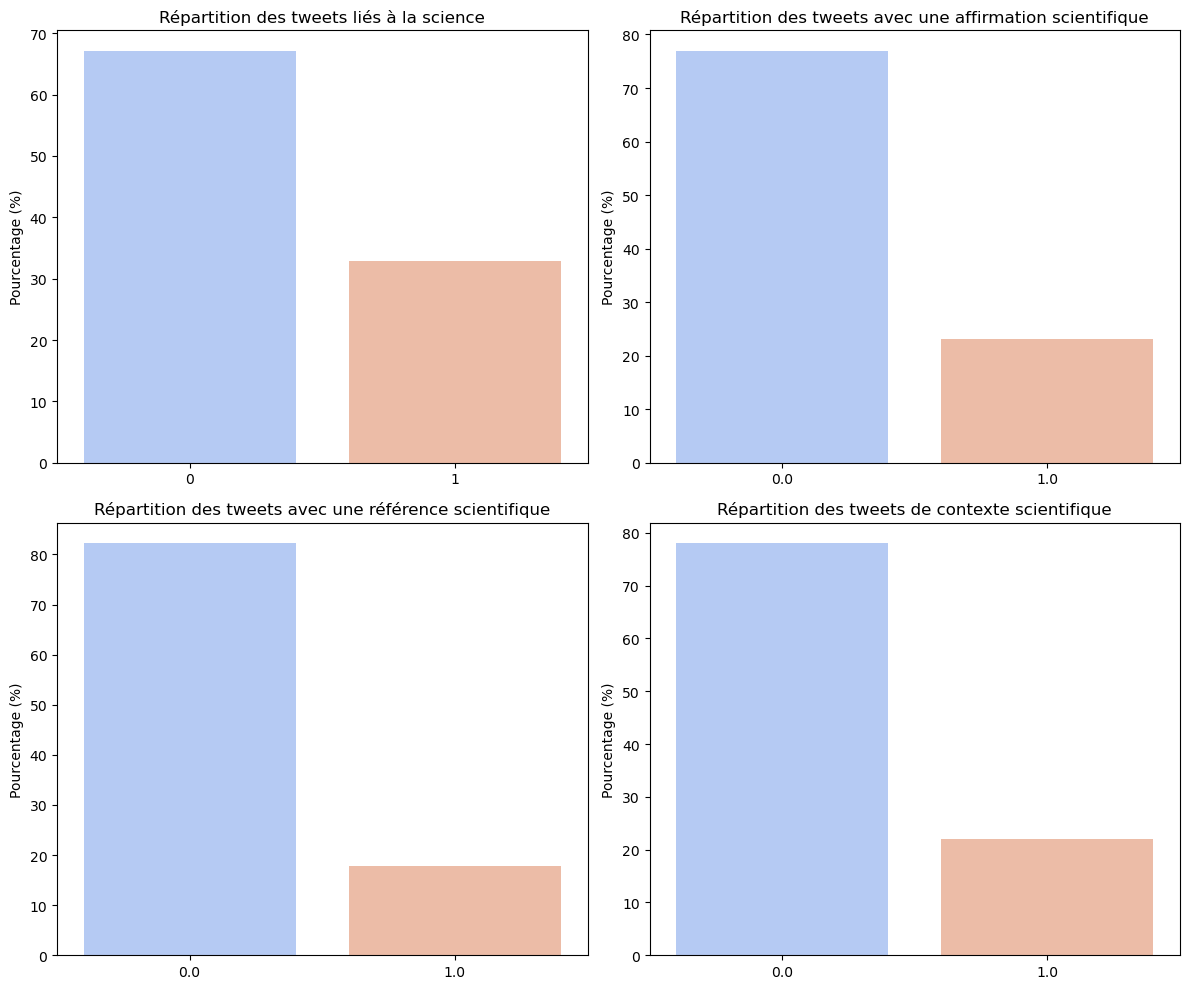

In [5]:
# Définir la figure avec 2 lignes et 2 colonnes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Liste des colonnes à afficher
columns = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']
titles = [
    "Répartition des tweets liés à la science",
    "Répartition des tweets avec une affirmation scientifique",
    "Répartition des tweets avec une référence scientifique",
    "Répartition des tweets de contexte scientifique"
]

# Générer les 4 countplots avec pourcentage
for ax, col, title in zip(axes.flat, columns, titles):
    total = len(df[col])  # Nombre total d'observations
    sns.barplot(
        x=df[col].value_counts(normalize=True).index,  # Valeurs uniques
        y=df[col].value_counts(normalize=True).values * 100,  # Pourcentage
        ax=ax, palette="coolwarm"
    )
    ax.set_title(title)
    ax.set_xlabel("")  # Supprimer les labels des axes X pour plus de lisibilité
    ax.set_ylabel("Pourcentage (%)")

# Ajuster l'espacement
plt.tight_layout()
plt.show()


On remarque que la majorité des tweets de notre dataset d'entrainement ne sont pas scienfifiques

### On regarde la densité de valeur présente

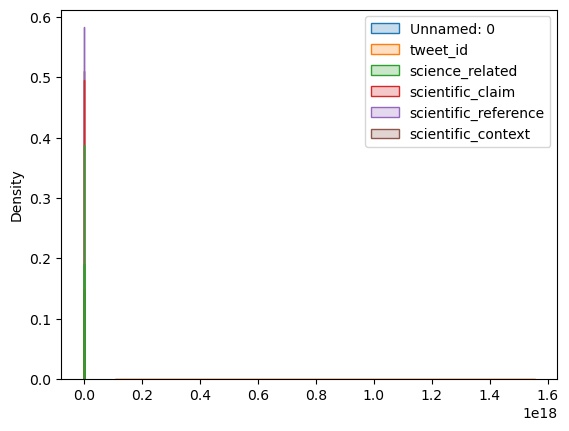

In [6]:
sns.kdeplot(data=df, fill=True)
plt.show()

# 2. Nettoyage des données

On a remarqué que certains tweets utilisant des mots qui n'était pas en anglais. Nous avons donc trouvé pour qu'un modèle fonctionne, il parait approprié de traduire les tweets en anglais. Pour cela nous allons utiliser les fonctionnalité de traduction proposé par Google. 

### Fonction pour traduire en anglais

In [7]:
!pip install deep-translator
!pip install mlutils
from deep_translator import GoogleTranslator

def translate_to_english(tweet):
    translated = GoogleTranslator(source='auto', target='en').translate(tweet)
    return translated

In [8]:
df['text'] = df['text'].apply(translate_to_english)
display(df)


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1135,1255,1340455669443350528,@LaylaFanucci @realDonaldTrump I'm sorry but w...,1,1.0,0.0,0.0
1136,1256,1340689510569549824,"Dear #NIN applicants, you can kindly download ...",0,0.0,0.0,0.0
1137,1258,1341155832793165825,Whats the uber support team email address?,0,0.0,0.0,0.0
1138,1259,1344167355648241664,House passes bill to increase stimulus checks ...,0,0.0,0.0,0.0


In [9]:
import itertools
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer # Racinisation des termes

# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Charger les données

# Définition des fonctions de prétraitement
def remove_links(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#', '', tweet, flags=re.MULTILINE)

def remove_mentions(tweet):
    return re.sub(r'\@\w+', '', tweet, flags=re.MULTILINE)

def remove_hashtags(tweet):
    return re.sub(r'\#+', '', tweet, flags=re.MULTILINE)

def to_lowercase(tweet):
    return tweet.lower()

def remove_punctuation(tweet):
    return re.sub(r'[^\w\s]', '', tweet)

def remove_stopwords(tweet):
    tokens = word_tokenize(tweet)
    return ' '.join([word for word in tokens if word not in stopwords.words('english')])

def lemmatize_words(tweet):
    tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

def stem_words(tweet):
    tokens = word_tokenize(tweet)
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tokens])


# Liste des transformations possibles
transformations = {
    "remove_links": remove_links,
    "to_lowercase": to_lowercase,
    "remove_punctuation": remove_punctuation,
    "remove_stopwords": remove_stopwords,
    "lemmatize_words": lemmatize_words,
    "remove_mentions": remove_mentions,
    "remove_hashtags": remove_hashtags,
    "stem_words": stem_words
}

# Générer toutes les combinaisons possibles des transformations
all_combinations = []
for i in range(1, len(transformations) + 1):
    all_combinations.extend(itertools.combinations(transformations.keys(), i))

# Stocker les résultats
results = []

# Boucle sur chaque combinaison de transformations
for i, combination in enumerate(all_combinations):
    df_copy = df.copy()
    
    # Appliquer les transformations sélectionnées
    for transform in combination:
        df_copy['text'] = df_copy['text'].apply(transformations[transform])
    
    # Séparation des données
    X = df_copy['text']
    y = df_copy['science_related']
    
    # Vectorisation simple avec TF-IDF
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X)

    # Séparation en train/test
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

    # Modèle Decision Tree
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    
    # Stocker les résultats
    results.append({"combination": combination, "accuracy": accuracy})
    print(f"Test {i+1}/{len(all_combinations)} - {combination} -> Accuracy: {accuracy:.4f}")

# Afficher les meilleurs résultats
results_df = pd.DataFrame(results)



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/geoffrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/geoffrey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/geoffrey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Test 1/255 - ('remove_links',) -> Accuracy: 0.7237
Test 2/255 - ('to_lowercase',) -> Accuracy: 0.7675
Test 3/255 - ('remove_punctuation',) -> Accuracy: 0.7368
Test 4/255 - ('remove_stopwords',) -> Accuracy: 0.7763
Test 5/255 - ('lemmatize_words',) -> Accuracy: 0.7237
Test 6/255 - ('remove_mentions',) -> Accuracy: 0.7851
Test 7/255 - ('remove_hashtags',) -> Accuracy: 0.7675
Test 8/255 - ('stem_words',) -> Accuracy: 0.7588
Test 9/255 - ('remove_links', 'to_lowercase') -> Accuracy: 0.7412
Test 10/255 - ('remove_links', 'remove_punctuation') -> Accuracy: 0.7456
Test 11/255 - ('remove_links', 'remove_stopwords') -> Accuracy: 0.7851
Test 12/255 - ('remove_links', 'lemmatize_words') -> Accuracy: 0.7149
Test 13/255 - ('remove_links', 'remove_mentions') -> Accuracy: 0.7500
Test 14/255 - ('remove_links', 'remove_hashtags') -> Accuracy: 0.7325
Test 15/255 - ('remove_links', 'stem_words') -> Accuracy: 0.7456
Test 16/255 - ('to_lowercase', 'remove_punctuation') -> Accuracy: 0.7456
Test 17/255 - ('t

In [10]:
best_results = results_df.sort_values(by="accuracy", ascending=False).head(5)
worst_results = results_df.sort_values(by="accuracy", ascending=False).tail(5)

print("\nTop 5 des meilleures combinaisons :")
print(best_results)

print("\nTop 5 des PIRES combinaisons :")
print(worst_results)


Top 5 des meilleures combinaisons :
                                           combination  accuracy
221  (remove_links, to_lowercase, remove_punctuatio...  0.811404
108  (remove_links, remove_punctuation, remove_stop...  0.802632
222  (remove_links, to_lowercase, remove_punctuatio...  0.802632
69    (to_lowercase, remove_mentions, remove_hashtags)  0.798246
251  (remove_links, to_lowercase, remove_stopwords,...  0.798246

Top 5 des PIRES combinaisons :
                                           combination  accuracy
52    (remove_links, lemmatize_words, remove_hashtags)  0.719298
51    (remove_links, lemmatize_words, remove_mentions)  0.719298
11                     (remove_links, lemmatize_words)  0.714912
203  (to_lowercase, remove_punctuation, lemmatize_w...  0.714912
31                  (lemmatize_words, remove_hashtags)  0.710526


In [11]:
# Calculer la moyenne des accuracy pour chaque transformation
average_accuracy = {}
for transform in transformations.keys():
    accuracies = [result['accuracy'] for result in results if transform in result['combination']]
    average_accuracy[transform] = sum(accuracies) / len(accuracies)

# Afficher les résultats
average_accuracy_df = pd.DataFrame(list(average_accuracy.items()), columns=['Transformation', 'Average Accuracy'])
average_accuracy_df = average_accuracy_df.sort_values(by='Average Accuracy', ascending=False)
print(average_accuracy_df)

       Transformation  Average Accuracy
3    remove_stopwords          0.770936
0        remove_links          0.764426
2  remove_punctuation          0.760896
1        to_lowercase          0.760828
5     remove_mentions          0.759800
6     remove_hashtags          0.759560
7          stem_words          0.759560
4     lemmatize_words          0.753050


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Transformation du texte en vecteurs TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limite à 5000 mots pour éviter la surcharge
X = vectorizer.fit_transform(df['text'])

# Définition de la variable cible
y = df['science_related']

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédiction sur les données test
y_pred = model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       146
           1       0.70      0.65      0.67        82

    accuracy                           0.77       228
   macro avg       0.75      0.74      0.75       228
weighted avg       0.77      0.77      0.77       228



In [13]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage simple
print("Matrice de confusion :")
print(cm)

# Explication des valeurs
tn, fp, fn, tp = cm.ravel()
print(f"\nVrais Négatifs  (TN) : {tn}")
print(f"Faux Positifs  (FP) : {fp}")
print(f"Faux Négatifs  (FN) : {fn}")
print(f"Vrais Positifs  (TP) : {tp}")

Matrice de confusion :
[[123  23]
 [ 29  53]]

Vrais Négatifs  (TN) : 123
Faux Positifs  (FP) : 23
Faux Négatifs  (FN) : 29
Vrais Positifs  (TP) : 53


Beaucoup de TP & TN → Modèle performant-> valeurs réelles bien guess
Beaucoup de FP → Modèle fait trop d'erreurs en classant des tweets non scientifiques comme scientifiques
Beaucoup de FN → Modèle rate des tweets scientifiques

# Modèles
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = classification_report(y_test, y_pred, output_dict=True)
    print(f"\nModèle : {name}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {name}")
    plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 18.2 MB/s eta 0:00:0000:0100:01

🔹 Entraînement du modèle: Régression Logistique

📊 Performance de Régression Logistique:
Accuracy: 0.816
Rapport de classification:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       146
           1       0.79      0.67      0.72        82

    accuracy                           0.82       228
   macro avg       0.81      0.78      0.79       228
weighted avg       0.81      0.82      0.81       228



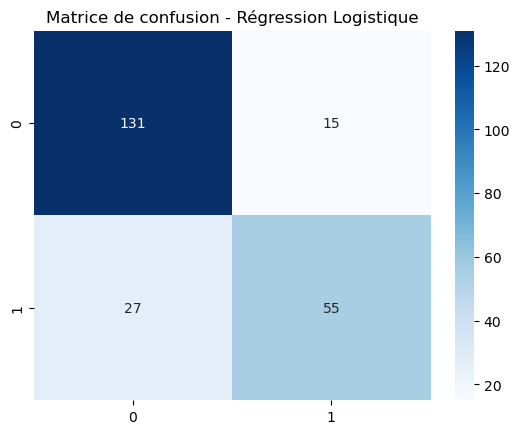


🔹 Entraînement du modèle: SVM Linéaire

📊 Performance de SVM Linéaire:
Accuracy: 0.803
Rapport de classification:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       146
           1       0.78      0.62      0.69        82

    accuracy                           0.80       228
   macro avg       0.80      0.76      0.77       228
weighted avg       0.80      0.80      0.80       228



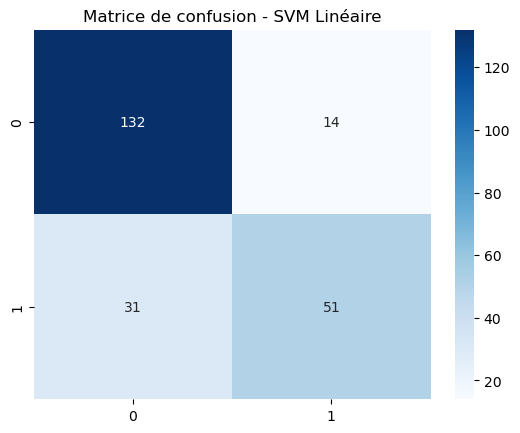


🔹 Entraînement du modèle: Naive Bayes

📊 Performance de Naive Bayes:
Accuracy: 0.684
Rapport de classification:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80       146
           1       1.00      0.12      0.22        82

    accuracy                           0.68       228
   macro avg       0.83      0.56      0.51       228
weighted avg       0.79      0.68      0.59       228



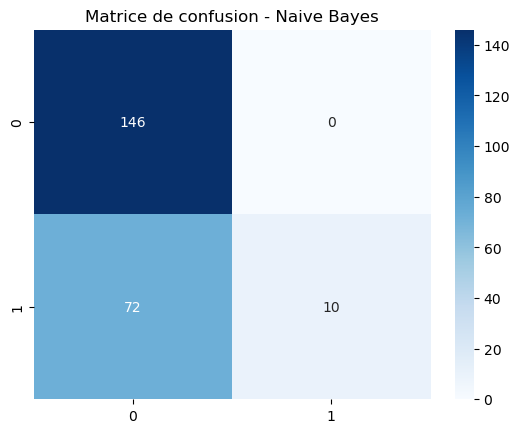


🔹 Entraînement du modèle: XGBoost


/home/geoffrey/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:57:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Performance de XGBoost:
Accuracy: 0.785
Rapport de classification:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       146
           1       0.75      0.60      0.67        82

    accuracy                           0.79       228
   macro avg       0.78      0.74      0.75       228
weighted avg       0.78      0.79      0.78       228



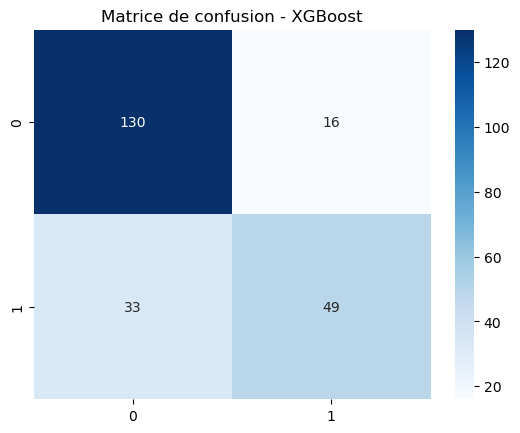


🔹 Entraînement du modèle: Perceptron Multicouche

📊 Performance de Perceptron Multicouche:
Accuracy: 0.772
Rapport de classification:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84       146
           1       0.77      0.52      0.62        82

    accuracy                           0.77       228
   macro avg       0.77      0.72      0.73       228
weighted avg       0.77      0.77      0.76       228



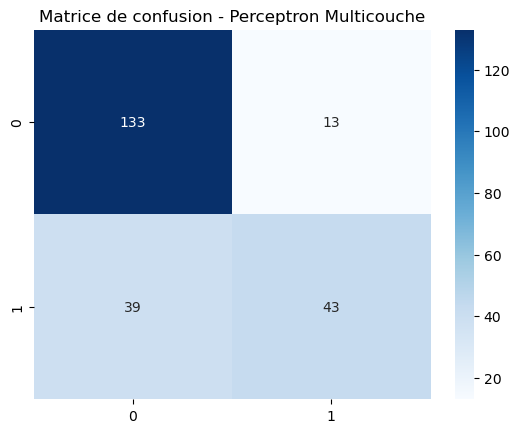


🏆 Comparaison finale des modèles:
Modèle                    Accuracy  
Régression Logistique     0.816
SVM Linéaire              0.803
Naive Bayes               0.684
XGBoost                   0.785
Perceptron Multicouche    0.772


In [14]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
!pip install XGBoost
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier

# Chargement des données (à adapter selon votre chemin)
df = pd.read_csv("scitweets_export.tsv", sep="\t")

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) # Limite le vocabulaire aux 5000 mots les plus fréquents
X = vectorizer.fit_transform(df['text']) # Utilisez 'processed_text' si disponible
y = df['science_related']

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionnaire pour stocker les résultats
results = {}

# Liste des modèles à tester
models = {
    "Régression Logistique": LogisticRegression(class_weight='balanced', max_iter=1000),
    "SVM Linéaire": LinearSVC(class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Perceptron Multicouche": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

# Entraînement et évaluation de chaque modèle
for name, model in models.items():
    print(f"\n🔹 Entraînement du modèle: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Stockage des résultats
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred)
    }
    
    # Affichage des résultats
    print(f"\n📊 Performance de {name}:")
    print(f"Accuracy: {results[name]['accuracy']:.3f}")
    print("Rapport de classification:\n", results[name]['report'])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {name}")
    plt.show()

# Comparaison finale
print("\n🏆 Comparaison finale des modèles:")
print("{:<25} {:<10}".format('Modèle', 'Accuracy'))
for name, res in results.items():
    print("{:<25} {:.3f}".format(name, res['accuracy']))

Détection des type REF

=== Classification avec caractéristiques spécifiques ===
Performance du modèle avec les caractéristiques spécifiques:
Accuracy: 0.8099
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.89       277
         1.0       0.00      0.00      0.00        65

    accuracy                           0.81       342
   macro avg       0.40      0.50      0.45       342
weighted avg       0.66      0.81      0.72       342



/home/geoffrey/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/geoffrey/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/geoffrey/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


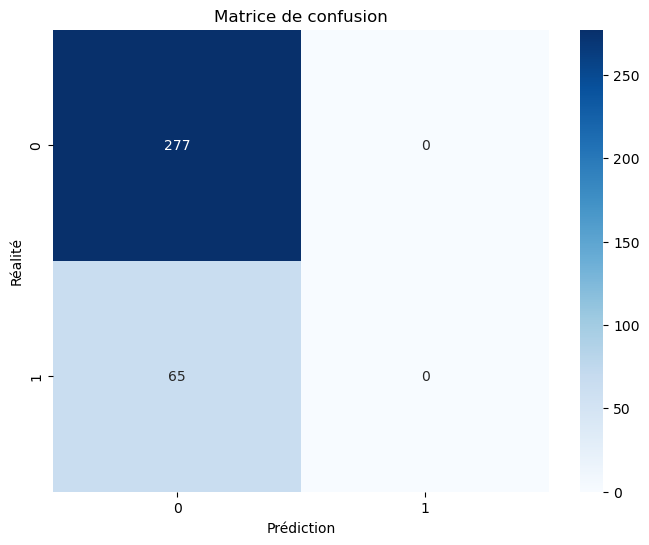

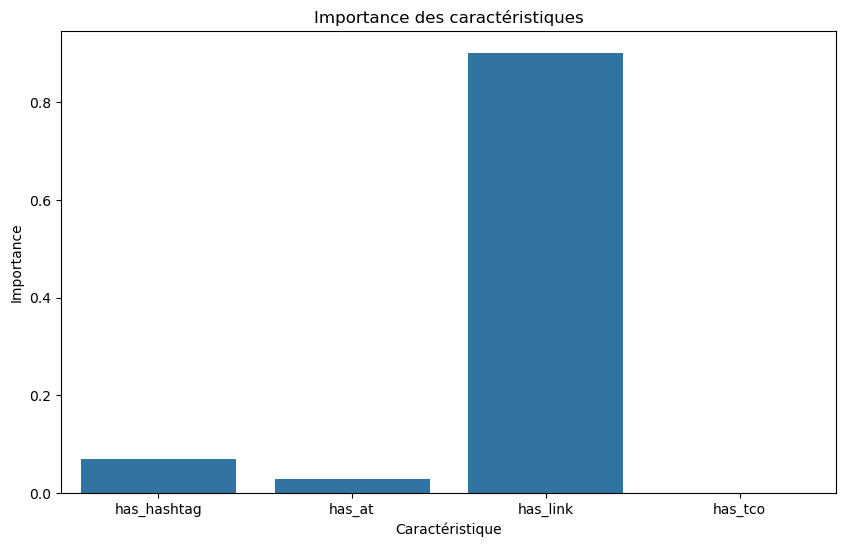


=== Comparaison avec approche TF-IDF ===

Performance du modèle avec TF-IDF:
Accuracy: 0.7953
Precision: 0.4627
Recall: 0.4769
F1 Score: 0.4697

=== Approche combinée (caractéristiques spécifiques + TF-IDF) ===

Performance du modèle combinant caractéristiques spécifiques et TF-IDF:
Accuracy: 0.7719
Precision: 0.3934
Recall: 0.3692
F1 Score: 0.3810

=== Validation croisée ===

Résultats de la validation croisée (5 plis):
Scores par pli: [0.8245614  0.8245614  0.82017544 0.82017544 0.82017544]
Score moyen: 0.8219
Écart-type: 0.0021

=== Optimisation de la profondeur de l'arbre ===
Profondeur 1: Accuracy = 0.8099
Profondeur 2: Accuracy = 0.8099
Profondeur 3: Accuracy = 0.8099
Profondeur 4: Accuracy = 0.8099
Profondeur 5: Accuracy = 0.8099
Profondeur 6: Accuracy = 0.8099
Profondeur 7: Accuracy = 0.8099
Profondeur 8: Accuracy = 0.8099
Profondeur 9: Accuracy = 0.8099
Profondeur 10: Accuracy = 0.8099


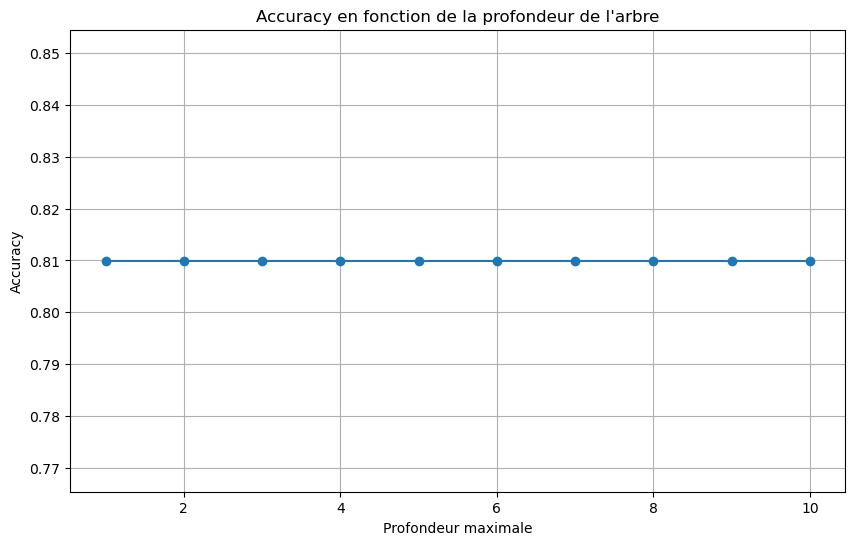

In [20]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

# Supposons que df soit déjà chargé avec les données du fichier TSV
# df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Fonction pour extraire les caractéristiques spécifiques (présence de #, @, liens)
def extract_features(text):
    has_hashtag = 1 if '#' in text else 0
    has_at = 1 if '@' in text else 0
    # Recherche de liens avec regex
    has_link = 1 if bool(re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)) else 0
    # Recherche de "t.co" qui est un raccourcisseur d'URL souvent utilisé par Twitter
    has_tco = 1 if 't.co' in text else 0
    
    return pd.Series([has_hashtag, has_at, has_link, has_tco])

def classify_scientific_reference():
    # Extraction des caractéristiques
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    
    # Sélection des caractéristiques et de la cible
    features = df[['has_hashtag', 'has_at', 'has_link', 'has_tco']]
    target = df['scientific_reference'].fillna(0)  # Remplacer les NaN par 0 pour éviter les erreurs
    
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    
    # Création et entraînement du modèle
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation des performances
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"Performance du modèle avec les caractéristiques spécifiques:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Afficher le rapport de classification détaillé
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))
    
    # Afficher la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.show()
    
    # Afficher l'importance des caractéristiques
    importances = model.feature_importances_
    feature_names = ['has_hashtag', 'has_at', 'has_link', 'has_tco']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=importances)
    plt.title('Importance des caractéristiques')
    plt.xlabel('Caractéristique')
    plt.ylabel('Importance')
    plt.show()
    
    return model

# Fonction pour comparer avec une approche utilisant TF-IDF pour compléter l'analyse
def compare_with_tfidf():
    # Préparation des données
    X = df['text']
    y = df['scientific_reference'].fillna(0)
    
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Extraction de caractéristiques avec TF-IDF
    vectorizer = CountVectorizer(max_features=100)  # Limiter à 100 mots les plus fréquents
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Création et entraînement du modèle
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_tfidf, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test_tfidf)
    
    # Évaluation des performances
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\nPerformance du modèle avec TF-IDF:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Fonction pour combiner les deux approches
def combined_approach():
    # Extraction des caractéristiques spécifiques
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    
    # Extraction de caractéristiques avec TF-IDF
    vectorizer = CountVectorizer(max_features=50)  # Limiter à 50 mots les plus fréquents
    tfidf_features = vectorizer.fit_transform(df['text'])
    
    # Convertir la matrice TF-IDF en DataFrame
    tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Joindre les caractéristiques spécifiques avec les caractéristiques TF-IDF
    combined_features = pd.concat([df[['has_hashtag', 'has_at', 'has_link', 'has_tco']].reset_index(drop=True), 
                                  tfidf_df.reset_index(drop=True)], axis=1)
    
    # Sélection de la cible
    target = df['scientific_reference'].fillna(0)
    
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(combined_features, target, test_size=0.3, random_state=42)
    
    # Création et entraînement du modèle
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation des performances
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\nPerformance du modèle combinant caractéristiques spécifiques et TF-IDF:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Fonction pour tester avec validation croisée
def test_with_cross_validation():
    # Préparation des données
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    features = df[['has_hashtag', 'has_at', 'has_link', 'has_tco']]
    target = df['scientific_reference'].fillna(0)  # Remplacer les NaN par 0
    
    # Création du modèle
    model = DecisionTreeClassifier(random_state=42)
    
    # Validation croisée avec 5 plis
    cv_scores = cross_val_score(model, features, target, cv=5)
    
    print("\nRésultats de la validation croisée (5 plis):")
    print(f"Scores par pli: {cv_scores}")
    print(f"Score moyen: {cv_scores.mean():.4f}")
    print(f"Écart-type: {cv_scores.std():.4f}")

# Fonction pour tester avec différentes profondeurs d'arbre
def optimize_tree_depth():
    # Préparation des données
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    features = df[['has_hashtag', 'has_at', 'has_link', 'has_tco']]
    target = df['scientific_reference'].fillna(0)  # Remplacer les NaN par 0
    
    # Division des données
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    
    # Test de différentes profondeurs
    depths = range(1, 11)
    accuracy_results = []
    
    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_results.append(accuracy)
        print(f"Profondeur {depth}: Accuracy = {accuracy:.4f}")
    
    # Visualisation des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(depths, accuracy_results, marker='o')
    plt.title('Accuracy en fonction de la profondeur de l\'arbre')
    plt.xlabel('Profondeur maximale')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# Fonction principale pour exécuter toutes les analyses
def main():
    # Exécuter l'analyse avec les caractéristiques spécifiques (présence de #, @, liens)
    print("=== Classification avec caractéristiques spécifiques ===")
    model = classify_scientific_reference()
    
    # Exécuter l'analyse avec TF-IDF
    print("\n=== Comparaison avec approche TF-IDF ===")
    compare_with_tfidf()
    
    # Exécuter l'analyse avec l'approche combinée
    print("\n=== Approche combinée (caractéristiques spécifiques + TF-IDF) ===")
    combined_approach()
    
    # Test avec validation croisée
    print("\n=== Validation croisée ===")
    test_with_cross_validation()
    
    # Optimisation de la profondeur de l'arbre
    print("\n=== Optimisation de la profondeur de l'arbre ===")
    optimize_tree_depth()

if __name__ == "__main__":
    main()